In [86]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [87]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

In [88]:
from torchvision import datasets, transforms
data_path = './data/07/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [89]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [90]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [91]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [92]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [93]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [94]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [95]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [96]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [97]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [98]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

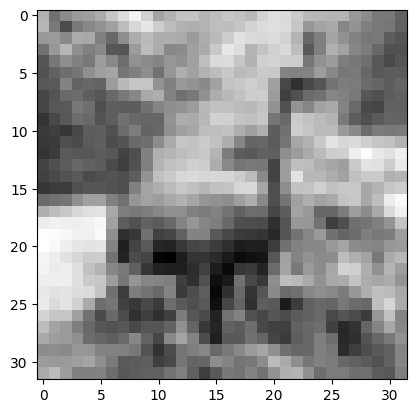

In [99]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

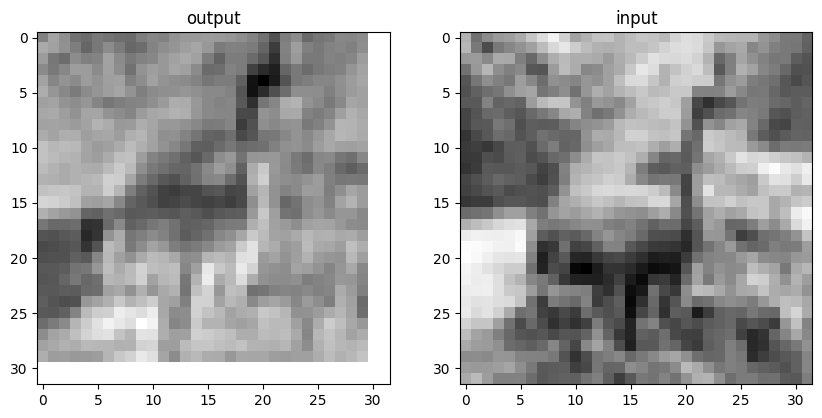

In [100]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [101]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [102]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

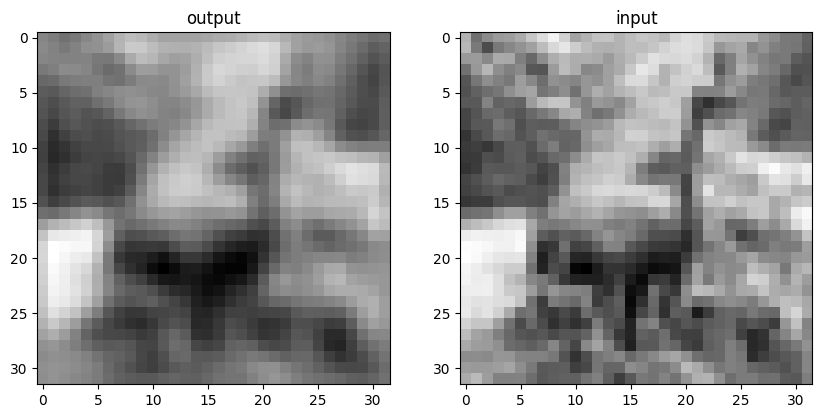

In [103]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [104]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

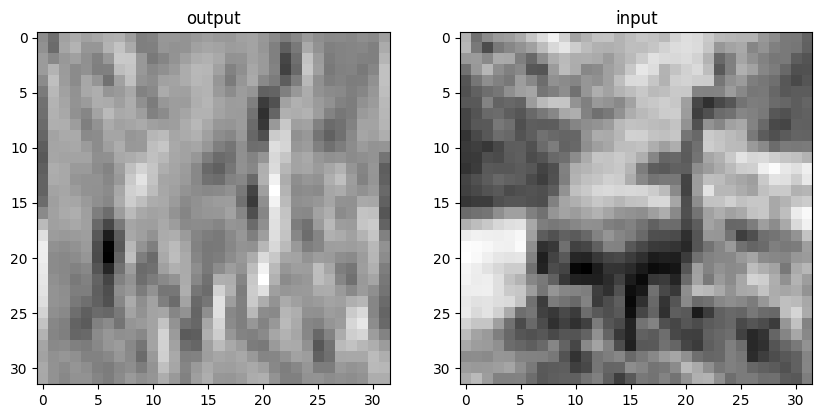

In [105]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [106]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [107]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [108]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [109]:
#model(img.unsqueeze(0))

In [110]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [111]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [112]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [113]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1720, 0.1507]], grad_fn=<AddmmBackward0>)

In [114]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [115]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-03-01 20:57:47.777909 Epoch 1, Training loss 0.5790962595848521
2024-03-01 20:57:52.499753 Epoch 10, Training loss 0.32672015999912457
2024-03-01 20:57:57.629853 Epoch 20, Training loss 0.29282316423145827
2024-03-01 20:58:02.464326 Epoch 30, Training loss 0.2706167881560933
2024-03-01 20:58:07.302287 Epoch 40, Training loss 0.25482018325169375
2024-03-01 20:58:12.420284 Epoch 50, Training loss 0.23748549733571944
2024-03-01 20:58:17.286964 Epoch 60, Training loss 0.22350192834047755
2024-03-01 20:58:22.109729 Epoch 70, Training loss 0.20881460236895616
2024-03-01 20:58:26.934317 Epoch 80, Training loss 0.19157554788194645
2024-03-01 20:58:31.786368 Epoch 90, Training loss 0.17864386908187987
2024-03-01 20:58:36.621670 Epoch 100, Training loss 0.16461189333230827


In [116]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.85


In [117]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [118]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [119]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [120]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [121]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-03-01 20:58:37.199309 Epoch 1, Training loss 0.5777228785927888
2024-03-01 20:58:38.557948 Epoch 10, Training loss 0.3230608157861005
2024-03-01 20:58:40.067225 Epoch 20, Training loss 0.29279716085096835
2024-03-01 20:58:41.563173 Epoch 30, Training loss 0.27225476436933893
2024-03-01 20:58:43.086728 Epoch 40, Training loss 0.25276578659084953
2024-03-01 20:58:44.596226 Epoch 50, Training loss 0.23581661910388121
2024-03-01 20:58:46.093162 Epoch 60, Training loss 0.22035449036177557
2024-03-01 20:58:47.602312 Epoch 70, Training loss 0.2026642907387132
2024-03-01 20:58:49.107818 Epoch 80, Training loss 0.18846296694627993
2024-03-01 20:58:50.596734 Epoch 90, Training loss 0.17573106421786508
2024-03-01 20:58:52.112280 Epoch 100, Training loss 0.16353302062222153


In [122]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [123]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [124]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [125]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2024-03-01 20:58:52.418323 Epoch 1, Training loss 0.5548406960857901
2024-03-01 20:58:53.865091 Epoch 10, Training loss 0.31351835778944054
2024-03-01 20:58:55.480958 Epoch 20, Training loss 0.2721285173657593
2024-03-01 20:58:57.099996 Epoch 30, Training loss 0.2415944955721023
2024-03-01 20:58:58.710842 Epoch 40, Training loss 0.21527561763669276
2024-03-01 20:59:00.316528 Epoch 50, Training loss 0.19103943684678168
2024-03-01 20:59:01.923546 Epoch 60, Training loss 0.1686341456451993
2024-03-01 20:59:03.526671 Epoch 70, Training loss 0.1473124397171151
2024-03-01 20:59:05.129318 Epoch 80, Training loss 0.12688949711288616
2024-03-01 20:59:06.736119 Epoch 90, Training loss 0.10756650039107557
2024-03-01 20:59:08.346942 Epoch 100, Training loss 0.09009331036477712
Accuracy train: 0.95
Accuracy val: 0.88


{'train': 0.947, 'val': 0.8765}

In [126]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [127]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2024-03-01 20:59:08.619194 Epoch 1, Training loss 0.5565084587236878
2024-03-01 20:59:10.062708 Epoch 10, Training loss 0.32359646545473936
2024-03-01 20:59:11.680377 Epoch 20, Training loss 0.279365995127684
2024-03-01 20:59:14.751946 Epoch 30, Training loss 0.2441633736631673
2024-03-01 20:59:16.977846 Epoch 40, Training loss 0.21409043052773566
2024-03-01 20:59:18.772511 Epoch 50, Training loss 0.18720415993860573
2024-03-01 20:59:20.498868 Epoch 60, Training loss 0.16306201840756804
2024-03-01 20:59:23.356202 Epoch 70, Training loss 0.1403707290056405
2024-03-01 20:59:25.837563 Epoch 80, Training loss 0.11905705603729387
2024-03-01 20:59:27.611887 Epoch 90, Training loss 0.0996927122235488
2024-03-01 20:59:29.512525 Epoch 100, Training loss 0.08266958553984666
Accuracy train: 0.96
Accuracy val: 0.90


In [128]:
sum(p.numel() for p in model.parameters())

38386

In [129]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [130]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2024-03-01 20:59:29.876204 Epoch 1, Training loss 0.5899160961816265
2024-03-01 20:59:32.159159 Epoch 10, Training loss 0.3584811920952645
2024-03-01 20:59:34.709401 Epoch 20, Training loss 0.3237489152486157
2024-03-01 20:59:37.206554 Epoch 30, Training loss 0.29962178704085624
2024-03-01 20:59:39.656680 Epoch 40, Training loss 0.2789958221897198
2024-03-01 20:59:42.265144 Epoch 50, Training loss 0.2624050137723327
2024-03-01 20:59:46.218167 Epoch 60, Training loss 0.24879261376751458
2024-03-01 20:59:48.686214 Epoch 70, Training loss 0.23695935375371557
2024-03-01 20:59:51.077063 Epoch 80, Training loss 0.22630375538282332
2024-03-01 20:59:53.422921 Epoch 90, Training loss 0.21651079652795366
2024-03-01 20:59:55.990825 Epoch 100, Training loss 0.20722951232248052
Accuracy train: 0.91
Accuracy val: 0.88


In [131]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [132]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2024-03-01 20:59:56.294112 Epoch 1, Training loss 0.5751752297210085
2024-03-01 20:59:57.888859 Epoch 10, Training loss 0.38667924521834984
2024-03-01 20:59:59.661665 Epoch 20, Training loss 0.35242496952889074
2024-03-01 21:00:01.422409 Epoch 30, Training loss 0.32864185000301166
2024-03-01 21:00:03.202865 Epoch 40, Training loss 0.31271198581738074
2024-03-01 21:00:04.977057 Epoch 50, Training loss 0.2952111726923353
2024-03-01 21:00:06.748349 Epoch 60, Training loss 0.28556843586028763
2024-03-01 21:00:08.526623 Epoch 70, Training loss 0.276067226365873
2024-03-01 21:00:10.302319 Epoch 80, Training loss 0.2617026287469135
2024-03-01 21:00:12.072123 Epoch 90, Training loss 0.2481494531225247
2024-03-01 21:00:13.842527 Epoch 100, Training loss 0.23607279782652096
Accuracy train: 0.89
Accuracy val: 0.87


In [133]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [134]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2024-03-01 21:00:14.166613 Epoch 1, Training loss 0.47805308460429974
2024-03-01 21:00:15.950542 Epoch 10, Training loss 0.2730734082543926
2024-03-01 21:00:17.912430 Epoch 20, Training loss 0.2125432598552886
2024-03-01 21:00:19.891355 Epoch 30, Training loss 0.1645543943307582
2024-03-01 21:00:21.882815 Epoch 40, Training loss 0.12062814316836892
2024-03-01 21:00:23.860020 Epoch 50, Training loss 0.08410762059413324
2024-03-01 21:00:25.822742 Epoch 60, Training loss 0.05599115603265299
2024-03-01 21:00:27.786258 Epoch 70, Training loss 0.03664658900801163
2024-03-01 21:00:29.757224 Epoch 80, Training loss 0.023973991501198454
2024-03-01 21:00:31.748739 Epoch 90, Training loss 0.018176401636094613
2024-03-01 21:00:34.597227 Epoch 100, Training loss 0.011525593594214909
Accuracy train: 0.99
Accuracy val: 0.88


In [135]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [136]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2024-03-01 21:00:35.312757 Epoch 1, Training loss 0.6844430767047177
2024-03-01 21:00:37.492325 Epoch 10, Training loss 0.35310128710831806
2024-03-01 21:00:39.472747 Epoch 20, Training loss 0.30568884844612926
2024-03-01 21:00:42.225180 Epoch 30, Training loss 0.27436445150405736
2024-03-01 21:00:44.300293 Epoch 40, Training loss 0.24456402692635348
2024-03-01 21:00:46.266141 Epoch 50, Training loss 0.21825084702414313
2024-03-01 21:00:48.246686 Epoch 60, Training loss 0.19346419569982845
2024-03-01 21:00:50.219971 Epoch 70, Training loss 0.16928461345897358
2024-03-01 21:00:52.181270 Epoch 80, Training loss 0.14542203510452986
2024-03-01 21:00:54.141061 Epoch 90, Training loss 0.11978917182156235
2024-03-01 21:00:56.106950 Epoch 100, Training loss 0.09374582800705722
Accuracy train: 0.94
Accuracy val: 0.89


In [137]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [138]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2024-03-01 21:00:56.446511 Epoch 1, Training loss 0.6643548049744527
2024-03-01 21:00:58.256114 Epoch 10, Training loss 0.3225715241994068
2024-03-01 21:01:00.249345 Epoch 20, Training loss 0.27578454184684026
2024-03-01 21:01:02.243669 Epoch 30, Training loss 0.24167408893822104
2024-03-01 21:01:04.238017 Epoch 40, Training loss 0.21449659973572774
2024-03-01 21:01:06.227186 Epoch 50, Training loss 0.18893354072882113
2024-03-01 21:01:08.222390 Epoch 60, Training loss 0.16408294600665949
2024-03-01 21:01:10.214910 Epoch 70, Training loss 0.1392554323527084
2024-03-01 21:01:12.208155 Epoch 80, Training loss 0.1136312786560909
2024-03-01 21:01:14.194147 Epoch 90, Training loss 0.08780469668281686
2024-03-01 21:01:16.182596 Epoch 100, Training loss 0.06494309376498127
Accuracy train: 0.97
Accuracy val: 0.89


In [139]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [140]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [141]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2024-03-01 21:01:20.269667 Epoch 1, Training loss 2.5053899907002783
2024-03-01 21:01:55.648288 Epoch 10, Training loss 0.39040672883486294
2024-03-01 21:02:35.731635 Epoch 20, Training loss 0.3106421661225094
2024-03-01 21:03:16.212097 Epoch 30, Training loss 0.24472194207701714
2024-03-01 21:03:55.886408 Epoch 40, Training loss 0.1975986220559497
2024-03-01 21:04:35.285496 Epoch 50, Training loss 0.15564123797378723
2024-03-01 21:05:14.886259 Epoch 60, Training loss 0.1211726908708454
2024-03-01 21:05:54.338076 Epoch 70, Training loss 0.13386365682313775
2024-03-01 21:06:33.685933 Epoch 80, Training loss 0.08029403701827974
2024-03-01 21:07:12.987298 Epoch 90, Training loss 0.05624014134281523
2024-03-01 21:07:52.462852 Epoch 100, Training loss 0.04920099662604985
Accuracy train: 0.98
Accuracy val: 0.86


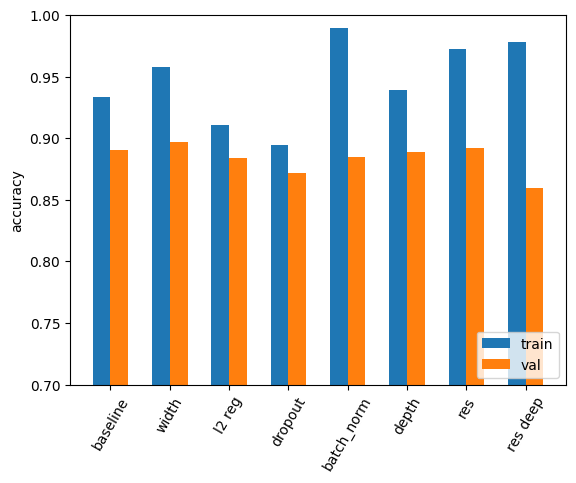

In [142]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()